In [ ]:
knitr::opts_chunk$set(echo = TRUE)

# Introduction 

The COPAS worm sorter allows fluorescence screening of a large number of worms in a short time. However, the output of machine is hard to interpret. Worms that go in the COPAS sorter can go in straight or turned over themselves. If the worm is turned on itself, that will overlap the florescence expression of its body and will create a different expression pattern in the data compared to a worm that went in straight. The WormSorter package was created to help visualize the objects better. The package allows the user to create their own SVM model to distinguish good worms (Worms that went in straight) from other unwanted objects. In the future, we'll be updating the package so the models created can be used to distinguish different expression patterns in the fluorescence channels. 

# How to get the package 

You can access the package's github through this link: https://github.com/ksnksa/WormSorter
You can also run this code to directly download the package in Rstudio.

In [1]:
devtools::install_github("ksnksa/WormSorter/WormSorter")

pillar (1.6.0 -> 1.6.1 ) [CRAN]
fansi  (0.4.2 -> 0.5.0 ) [CRAN]
proxy  (NA    -> 0.4-25) [CRAN]
tibble (3.1.1 -> 3.1.2 ) [CRAN]
e1071  (NA    -> 1.7-7 ) [CRAN]


Installing 5 packages: pillar, fansi, proxy, tibble, e1071

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“'lib = "/usr/local/lib/R/site-library"' is not writable”


ERROR: Error: Failed to install 'WormSorter' from GitHub:
  unable to install packages


Then you can load the package by simply running

In [2]:
library("WormSorter")

# What data set to use 

The COPAS worm sorter outputs more than one file for each run. (NameOfRun)_profile.txt which contains the general information of all the objects and four (NameOfRun)_profile_ch#_prf.txt files (the # goes from 0 to 3) which contain the data from each channel. We’ll only be using the last four files. If you just want to follow this example, the tutorial loads the example files directly from our github repository. 

# How to get the annotated IDs 

We also use another csv file that contains annotated objects and their IDs. We'll be using this file to create our model. To create your own annotation, you can go to our [website](https://wormbuilder.dev/WormProfiler/).
The website allows you to visualize the object's channel data. 

![](https://raw.githubusercontent.com/ksnksa/WormSorter/main/WormProfiler.PNG)

1: Load the four channel data files then press submit.  2: The output plot of the selected object. 3: Here you can select which object ID you'd like to view. 4: You can check which channel you'd like to be in the plot. 5: The swipe right and swipe left buttons allow you to annotate the objects. Swiping right means annotating this object as a good worm, and swiping left means annotating this object as a bad worm. After annotating any number of objects, a button will pop up to download the annotated IDs. 

![](https://raw.githubusercontent.com/ksnksa/WormSorter/main/Download.PNG)

# Running the pipeline 

In [4]:

##Loading the libraries
library(e1071)
library(ggplot2)
library(reshape)
library(WormSorter)

## Loading the data 

In this example, we used a sample data set generated by the [Laboratory of Synthetic Genome Biology](https://syngenbio.kaust.edu.sa/). You can run the following code to use the same data set and annotated IDs files we're using. Ch0D, Ch1D, Ch2D, Ch3D, are the paths for each channel profile. GoodIDD is the path to the annotated IDs csv file.

In [5]:
#Channel directory taken from the WormSorter github
#When using your own data simply change these links to the file directory of the channels. 
Ch0D <- 'https://raw.githubusercontent.com/ksnksa/WormSorter/main/data/N2/n2_profil_ch0_prf.txt'
Ch1D <- 'https://raw.githubusercontent.com/ksnksa/WormSorter/main/data/N2/n2_profil_ch1_prf.txt'
Ch2D <- 'https://raw.githubusercontent.com/ksnksa/WormSorter/main/data/N2/n2_profil_ch2_prf.txt'
Ch3D <- 'https://raw.githubusercontent.com/ksnksa/WormSorter/main/data/N2/n2_profil_ch3_prf.txt'
#CSV file containing the levels (or annotation) for each worm in our training set. 
GoodIDD <- 'https://raw.githubusercontent.com/ksnksa/WormSorter/main/data/N2/GoodIDsNew.csv'

## Setting up the parameters 

The following parameters can be changed to suit the user's needs. MaxAmp, MinLength and MaxLength are parameters that control the initial filtering in this pipeline. MaxAmp is simply the maximum amplitude that an object can have. MinLength and MaxLength determine the minimum and maximum time of flight for each object. The purpose of this filtering, is to remove unwanted bubbles or artifacts. ChannelToCluster determines which channel the pipeline will work with. 1 is for Channel 0, 2 for Channel 1 and so on. Stage determines what worm stage the program will cluster. The package assigns the stage of each worm depending on the time of travel. The thresholds for the time of travel were taken from the COPASutils package (1).

In [6]:
#Setting up the parameters we need for the analysis
# Max amplitude an object can have 
# Anything more will be filitered out
MaxAmp <- 64000
# Minimum and maximum time of flight for each object
MinLength <- 40
MaxLength <- 500
# Which channel the pipeline will work on 
# 1 is for Channel 0, 2 is for Channel 1 
# 3 is for Channel 2, 4 is for Channel 3
ChannelToCluster <- 1
# Which stage the piepile will work on
# 1 is for L1, 2 is for L2/3 
# 3 is for L4, 4 is for Adults
Stage <- 4

## Example run 

### Loading the data

First we load up the channel data and apply an initial filter. Then we load up the annotated IDs csv file and create a variable that has the data for the worms that were annotated. 

In [7]:
# The ReadChannel function simply takes in the channel directories and returns a list with all
# the channels data.
channellist <- ReadChannel(Ch0D,Ch1D,Ch2D,Ch3D)
# Then we use the FilterChannel function to filter the data using our parameters. 
# The resulting index is the index of the objects we don't want. So we remove those indexes
# from the channel data. 
Index <- FilterChannel(channellist[[ChannelToCluster]],MaxAmp,MinLength,MaxLength)
channellist[[ChannelToCluster]] <- as.data.frame(channellist[[ChannelToCluster]][-c(Index),])
# The AssignStage function will take in the channel data and sorts the worms into four
# stages (L1, L2/3, L4, Adult). 
StageList <- AssignStage(channellist[[ChannelToCluster]])
# The CreateTrainingSetIDs function translates the annotated IDs csv 
# file to the data we have and gives out the index of the worms that are annotated.
WormIDs <- CreateTrainingSetIDs(StageList[[Stage]],GoodIDD)

Now we need to find out how many annotated worms do we have in the stage we're interested in. 

In [8]:
# Let's find how many worms are in our training set
# WormCount returns the number of annotated good and bad worms in the stage of interest.  
print(WormCount(StageList[[Stage]],WormIDs))

[1] "Number of Good Worms: 80 Number of Bad Worms: 76"


Now we know the maximum number of worms in the training set is 80 annotated good worms and 76 bad worms. 

### Model testing 

#### Bootstrap Analysis 

Our goal is to have a model that has a low number of worms, high accuracy and low standard deviation (meaning it is consistent). One way to test all of that, is to use a bootstrap analysis method. Bootstrapping in this context is simply using random sampling to find the accuracy of our model.
NumberOfBadWorms is how many bad worms will be in the training set and it can only be a single number. NumberOfGoodWorms is how many good worms will be in the training set. This variable can be a vector of different numbers. NumberOfRuns determines how many times the bootstrap analysis will run to check the accuracy of the model. 

In [9]:
# How many bad worms will be picked to make the training set
NumberOfBadWorms  = 30
# How many good worms will be picked to make the training set 
# Can be a vector of different numbers
NumbersOfGoodWorms  = c(70,60,50,40,30,20,10)
# How many times the bootstrap loop will run 
NumberOfRuns  = 100

This is the bootstrap loop. Depending on the parameters we set, it will loop a number of times and use random sampling to create a new training and prediction set in each loop. Those sets are annotated so any prediction can be compared to the original annotation to find the accuracy. After the loop is done running, we can take the average accuracy of the models and plot them. 

You can find how I calculated the accuracy in this [picture](https://raw.githubusercontent.com/ksnksa/WormSorter/main/Confusion-matrix-and-performance-equations-The-confusion-matrix-included-four.png) (2). 

Feel free to use any other method to find the accuracy of your model. 

In [10]:

Accuracy <- data.frame()
for (l in 1:length(NumbersOfGoodWorms)) {
  for (o in 1:NumberOfRuns) {
    SetList<- RandomTrainingSet(StageList[[Stage]],WormIDs,NumbersOfGoodWorms[l],NumberOfBadWorms)
    Pred <- GetPrediction(SetList)[[1]]
    Positive <- rownames(SetList[[2]][which(Pred==2),])
    TP <- sum((Positive %in% WormIDs[[1]]), na.rm = TRUE)
    Negative <- rownames(SetList[[2]][which(Pred==1),])
    TN <- length(Negative %in% WormIDs[[2]]) - sum((Negative %in% WormIDs[[1]]), na.rm = TRUE)
    Accuracy[l,o] <- (TP + TN) / (length(Positive) + length(Negative))
  }

}


Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V484’ and ‘V485’ and ‘V486’ and ‘V487’ and ‘V488’ and ‘V489’ and ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V489’ and ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V485’ and ‘V486’ and ‘V487’ and ‘V488’ and ‘V489’ and ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V489’ and ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V485’ and ‘V486’ and ‘V487’ and ‘V488’ and ‘V489’ and ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V486’ and ‘V487’ and ‘V488’ and ‘V489’ and ‘V490’ and ‘V491’ and ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V492’ and ‘V493’ and ‘V494’ and ‘V495’ and ‘V496’ and ‘V497’ and ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ an

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

#### Accuracy Plot 

We can then view our accuracy plot to gauge how well the model performs. 

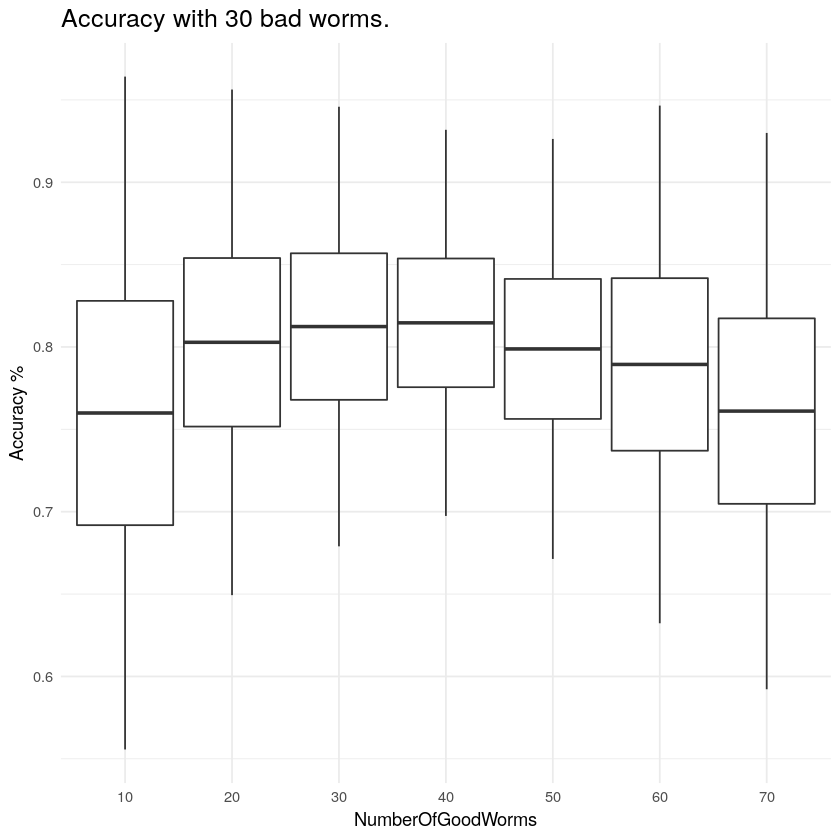

In [11]:
p <- PlotAccuracy(Accuracy, NumbersOfGoodWorms, NumberOfBadWorms)
## view the accuracy plot to get a sense of your model's efficiency
plot(p)

It looks like the model performs best when the number of good worms and bad worms is 30.  

### Clustering data 

After we created a suitable model, we can test it on another data set. For now, We'll use the sample data set we provided. Note: Since the training set was taken from this data set, there will be a bias with the clustering. This bias can be removed if you remove the training set from the data set.

ModelGood and ModelBad are the number of good and bad worms that will be in the model. 


In [12]:
ModelGood <- 30
ModelBad <- 30
# RandomTrainingSet creates a training set out of the following parameters: 
# The channel data, annotated worm IDs and how many good and bad worms will be in the model. 
SetList<- RandomTrainingSet(StageList[[Stage]],WormIDs,ModelGood,ModelBad)

# CreateModel takes in the training set to create a model.
model <- CreateModel(SetList[[2]])
# RunModel runs the model againts the inputted channel data 
# and outputs the clustering prediction. 
# To run the model against another data set, simply change the StageList[[Stage]] variable. 
Pred <- RunModel(StageList[[Stage]], model)

Warning message in svm.default(m, y, type = "C-classification", scale = TRUE, kernel = "linear"):
“Variable(s) ‘V498’ and ‘V499’ and ‘V500’ and ‘V501’ and ‘V502’ and ‘V503’ and ‘V504’ and ‘V505’ and ‘V506’ and ‘V507’ and ‘V508’ and ‘V509’ and ‘V510’ and ‘V511’ and ‘V512’ and ‘V513’ and ‘V514’ and ‘V515’ and ‘V516’ and ‘V517’ and ‘V518’ and ‘V519’ and ‘V520’ and ‘V521’ and ‘V522’ and ‘V523’ and ‘V524’ and ‘V525’ and ‘V526’ and ‘V527’ and ‘V528’ and ‘V529’ and ‘V530’ and ‘V531’ and ‘V532’ and ‘V533’ and ‘V534’ and ‘V535’ and ‘V536’ and ‘V537’ and ‘V538’ and ‘V539’ and ‘V540’ and ‘V541’ and ‘V542’ and ‘V543’ and ‘V544’ and ‘V545’ and ‘V546’ and ‘V547’ and ‘V548’ and ‘V549’ and ‘V550’ and ‘V551’ and ‘V552’ and ‘V553’ and ‘V554’ and ‘V555’ and ‘V556’ and ‘V557’ and ‘V558’ and ‘V559’ and ‘V560’ and ‘V561’ and ‘V562’ and ‘V563’ and ‘V564’ and ‘V565’ and ‘V566’ and ‘V567’ and ‘V568’ and ‘V569’ and ‘V570’ and ‘V571’ and ‘V572’ and ‘V573’ and ‘V574’ and ‘V575’ and ‘V576’ and ‘V577’ and ‘V578’ an

#### Prediction Plots 

Now we can plot the results of the clustering. 

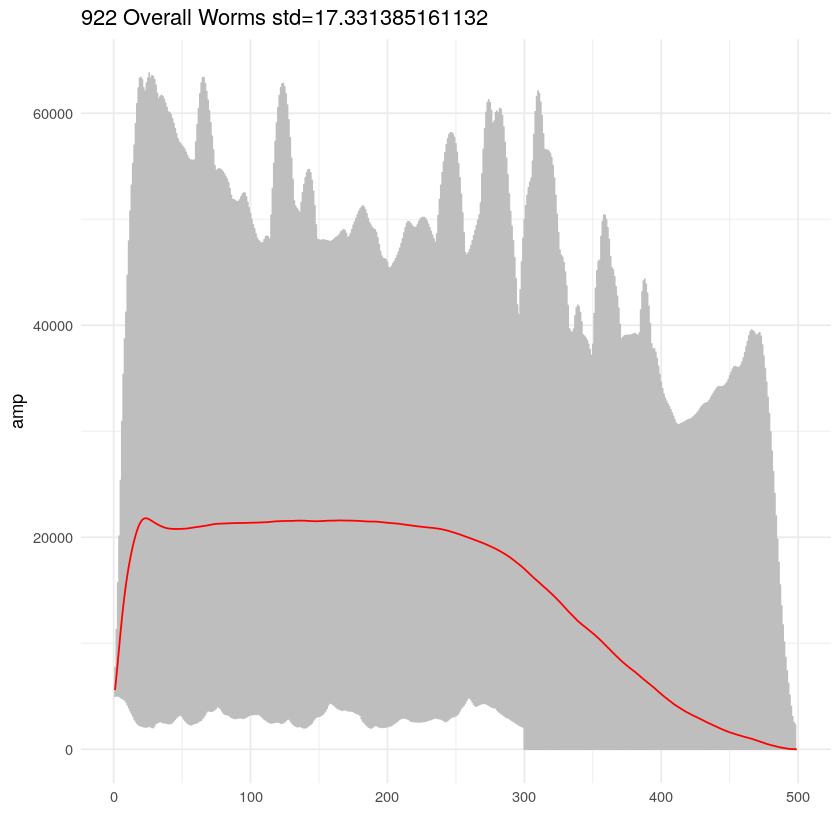

In [13]:

# PlotPred takes in the prediction and the channel data to output three plots: 
# A plot with all the worms in the channel data, 
# a plot with the clustered bad worms and a plot with the clustered good worms. 
Plots <- PlotPred(Pred, StageList[[Stage]])
# To view them we can simply use the plot function
# Plot 1: The over all plot of all the worms
plot(Plots[[1]])


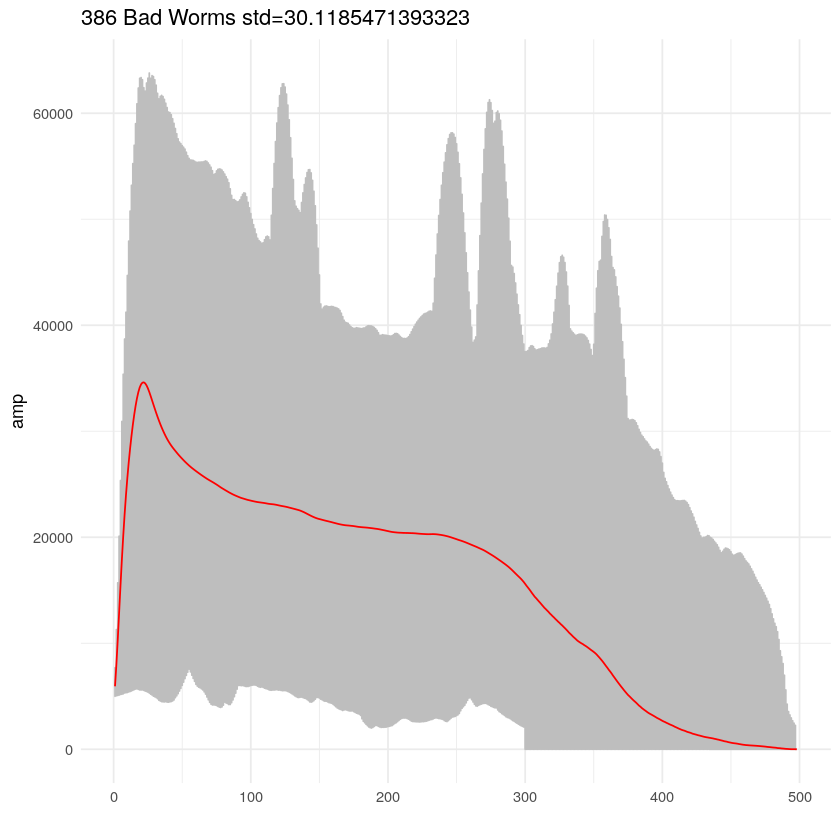

In [14]:
# Plot 2: The bad worms
plot(Plots[[2]])


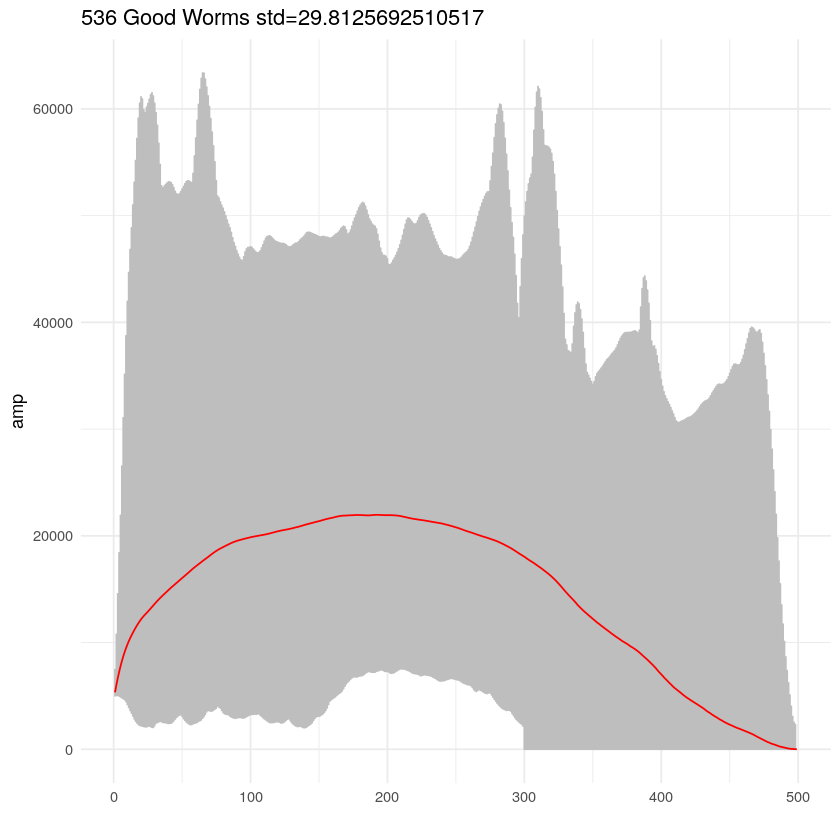

In [15]:
# Plot 3: The good worms
plot(Plots[[3]])

Overall, we'd like our good worms to look like this plot. A smooth curve is indicative that the worms went in straight in the COPAS sorter.   

# References 

1- Article Source: COPASutils: An R Package for Reading, Processing, and Visualizing Data from COPAS Large-Particle Flow Cytometers
Shimko TC, Andersen EC (2014) COPASutils: An R Package for Reading, Processing, and Visualizing Data from COPAS Large-Particle Flow Cytometers. PLOS ONE 9(10): e111090. https://doi.org/10.1371/journal.pone.0111090 

2- Niu, Jiajia & An, Guoshuai & Gu, Zhen & Li, Peng & Liu, Qiqing & Bai, Rufeng & Sun, Jun-Hong & Du, Qiu-Xiang. (2020). Analysis of sensitivity and specificity: precise recognition of neutrophils during regeneration of contused skeletal muscle in rats. Forensic Sciences Research. 1-10. 10.1080/20961790.2020.1713432. 